# <span style="color:#873600; font-family: Trebuchet MS; font-size: 80px; font-weight: bold;">Iris Dataset</span>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\rahim\Desktop\LEARNING\PYTHON\PYTHON 7\Iris.csv")
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


# <span style="color:#873600; font-family: Trebuchet MS; font-size: 50px; font-weight: bold;">Data Preparation</span>

In [4]:
#Checking for null values. None found.
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [5]:
df.duplicated().sum().any()

False

In [6]:
#Checking for duplicates. None found.
len(df) == len(df.drop_duplicates())

True

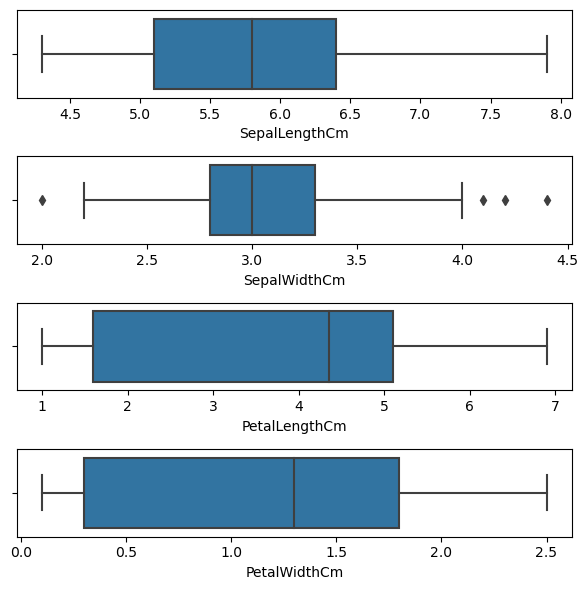

In [7]:
# Checking if there are any outliers in the dataset
fig, axes = plt.subplots(nrows=4, figsize=(6, 6))
sns.boxplot(ax=axes[0],x=df['SepalLengthCm'], data=df)
sns.boxplot(ax=axes[1],x=df['SepalWidthCm'], data=df)
sns.boxplot(ax=axes[2],x=df['PetalLengthCm'], data=df)
sns.boxplot(ax=axes[3],x=df['PetalWidthCm'], data=df)
plt.tight_layout()

In [8]:
#Discarding outliers. 
columns = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']

lower_list = []
upper_list = []

for col in columns:
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1
    lower = q1 - iqr*1.5
    upper = q3 + iqr*1.5
    lower_list.append(lower)
    upper_list.append(upper)

for lower,upper,col in zip(lower_list,upper_list,columns):
    df = df[(df[col]>lower) & (df[col]<upper)].copy()

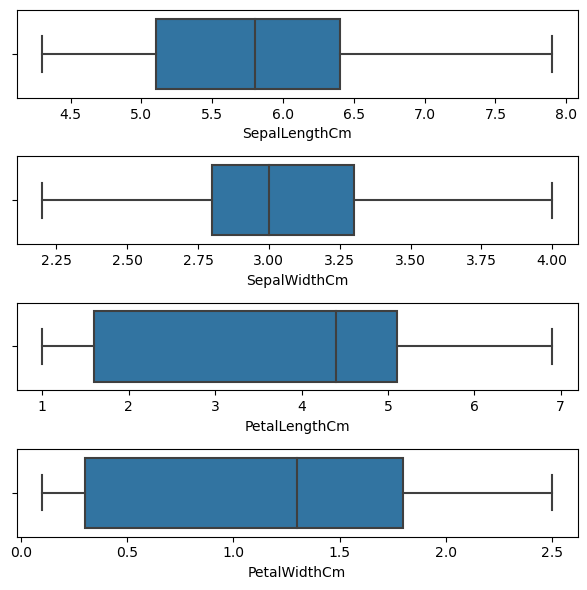

In [9]:
#All outliers have been removed
fig, axes = plt.subplots(nrows=4,figsize=(6,6))
sns.boxplot(ax=axes[0],x=df['SepalLengthCm'],data=df)
sns.boxplot(ax=axes[1],x=df['SepalWidthCm'],data=df)
sns.boxplot(ax=axes[2],x=df['PetalLengthCm'],data=df)
sns.boxplot(ax=axes[3],x=df['PetalWidthCm'],data=df)
plt.tight_layout()

In [10]:
#Dropping the Id column because it is useless in predicting the cluster
df = df.drop('Id',axis=1)
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


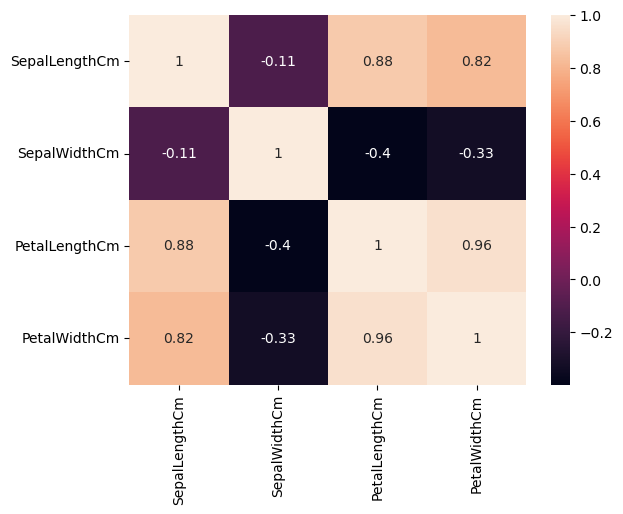

In [12]:
#Checking for multicolinearity. PetalLengthCm is strongly correlated with PetalWidthCm and SepalLengthCm.
# It might be useful to conduct dimensionality reduction and reduce those 3 features to 1 feature.
sns.heatmap(df.corr(),annot=True)
plt.show()

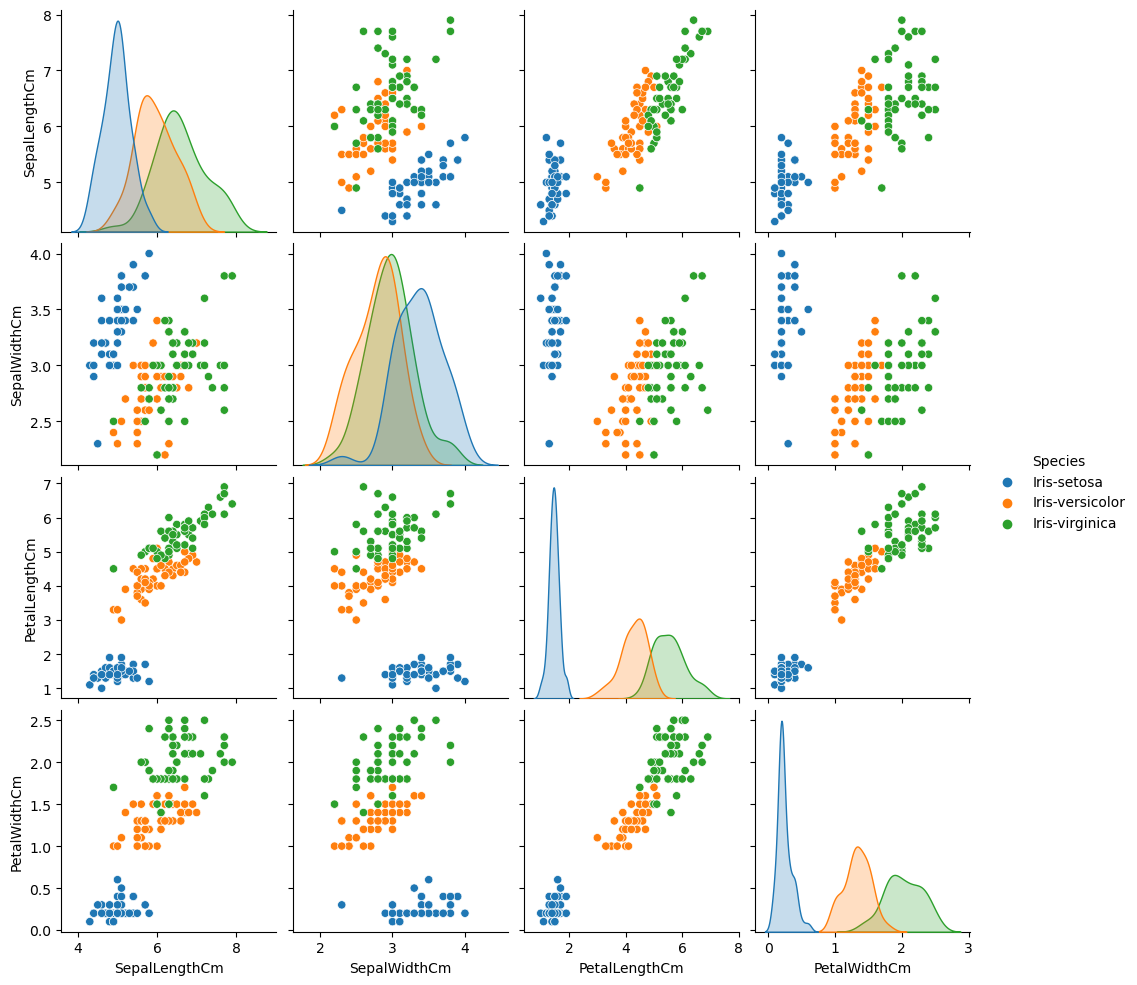

In [57]:
#It is obvious that Iris-setosa can be easily recognized as a separate cluster, due to its distinct features.
#The difference between Iris-versicolor and Iris-virginica on the other hand, is not very obvious.
sns.pairplot(df, hue="Species")
plt.show()

In [58]:
#Getting the features based on which we will predict the clusters
X = df.iloc[:,:-1].copy()

In [59]:
#First, we will build models without dimensionality reduction.
#We first need to scale our data, because the models that we will use, compute the distance between the datapoints.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# <span style="color:#873600; font-family: Trebuchet MS; font-size: 50px; font-weight: bold;">KMeans without PCA</span>

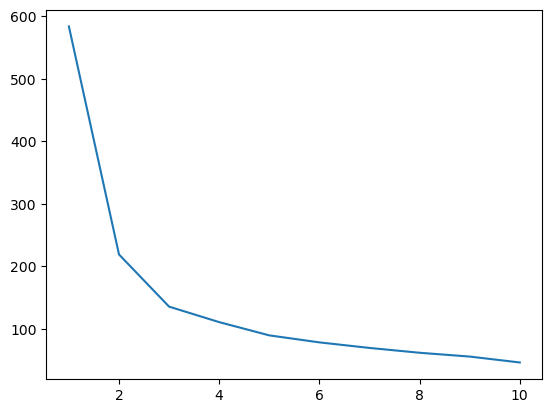

In [60]:
#We will now use the elbow method to determine the optimal number of clusters.
#First we compute the squared sum of distances for each number of clusters chosen.
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state= 123)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11),wcss)
plt.show()

In [61]:
#As expected, the elbow method has predicted that the optimal cluster number is 3.
#Let's now check the average predicted silhouette for different numbers of clusters.
#The silhouette method predicts that the number of clusters = 2 is optimal. 
#However, based on the elbow method, and based on our knowledge of the label, we will use 3 as the number of clusters.
range_n_clusters = [2, 3, 4, 5, 6,7,8,9]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5802862813877144
For n_clusters = 3 The average silhouette_score is : 0.46634515335503746
For n_clusters = 4 The average silhouette_score is : 0.4147413662578325
For n_clusters = 5 The average silhouette_score is : 0.3536366844284736
For n_clusters = 6 The average silhouette_score is : 0.34643762587959837
For n_clusters = 7 The average silhouette_score is : 0.35861998854550875
For n_clusters = 8 The average silhouette_score is : 0.36615827809451956
For n_clusters = 9 The average silhouette_score is : 0.3631520369076253


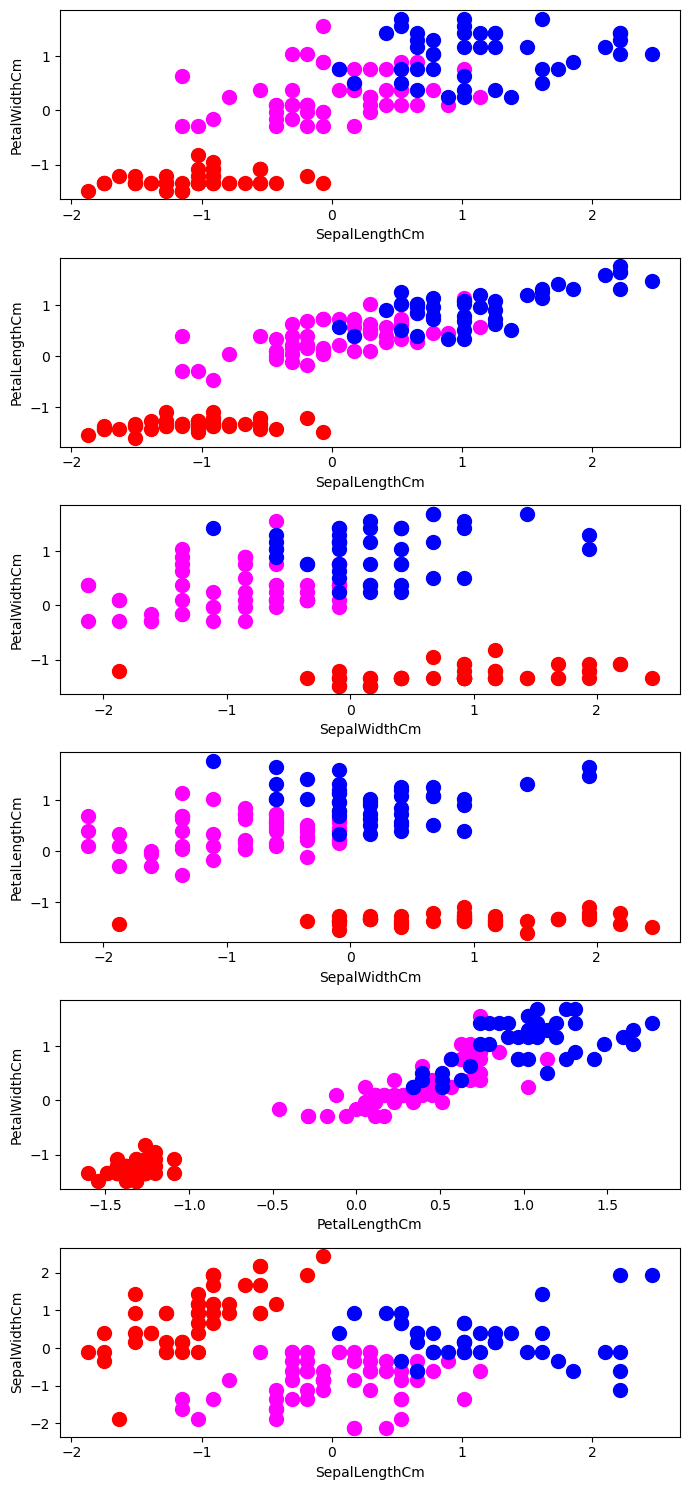

In [39]:
# The clusters have been visualised for every single feature. The separation appears to be good.
fig, axes = plt.subplots(nrows = 6, ncols=1, figsize=(7,15))
kmeans = KMeans(n_clusters = 3, random_state=42)
y_kmeans= kmeans.fit_predict(X)
axes[0].scatter(X[y_kmeans==0,0],X[y_kmeans==0,3],s=100,c='magenta')
axes[0].scatter(X[y_kmeans==1,0],X[y_kmeans==1,3],s=100,c='red')
axes[0].scatter(X[y_kmeans==2,0],X[y_kmeans==2,3],s=100,c='blue')
axes[0].set_xlabel('SepalLengthCm')
axes[0].set_ylabel('PetalWidthCm')
axes[1].scatter(X[y_kmeans==0,0],X[y_kmeans==0,2],s=100,c='magenta')
axes[1].scatter(X[y_kmeans==1,0],X[y_kmeans==1,2],s=100,c='red')
axes[1].scatter(X[y_kmeans==2,0],X[y_kmeans==2,2],s=100,c='blue')
axes[1].set_xlabel('SepalLengthCm')
axes[1].set_ylabel('PetalLengthCm')
axes[2].scatter(X[y_kmeans==0,1],X[y_kmeans==0,3],s=100,c='magenta')
axes[2].scatter(X[y_kmeans==1,1],X[y_kmeans==1,3],s=100,c='red')
axes[2].scatter(X[y_kmeans==2,1],X[y_kmeans==2,3],s=100,c='blue')
axes[2].set_xlabel('SepalWidthCm')
axes[2].set_ylabel('PetalWidthCm')
axes[3].scatter(X[y_kmeans==0,1],X[y_kmeans==0,2],s=100,c='magenta')
axes[3].scatter(X[y_kmeans==1,1],X[y_kmeans==1,2],s=100,c='red')
axes[3].scatter(X[y_kmeans==2,1],X[y_kmeans==2,2],s=100,c='blue')
axes[3].set_xlabel('SepalWidthCm')
axes[3].set_ylabel('PetalLengthCm')
axes[4].scatter(X[y_kmeans==0,2],X[y_kmeans==0,3],s=100,c='magenta')
axes[4].scatter(X[y_kmeans==1,2],X[y_kmeans==1,3],s=100,c='red')
axes[4].scatter(X[y_kmeans==2,2],X[y_kmeans==2,3],s=100,c='blue')
axes[4].set_xlabel('PetalLengthCm')
axes[4].set_ylabel('PetalWidthCm')
axes[5].scatter(X[y_kmeans==0,0],X[y_kmeans==0,1],s=100,c='magenta')
axes[5].scatter(X[y_kmeans==1,0],X[y_kmeans==1,1],s=100,c='red')
axes[5].scatter(X[y_kmeans==2,0],X[y_kmeans==2,1],s=100,c='blue')
axes[5].set_xlabel('SepalLengthCm')
axes[5].set_ylabel('SepalWidthCm')
plt.tight_layout()

In [62]:
# We will now check in how many cases we have predicted the label correctly. 
# According to the analysis, conducted above, the clusters that represent Iris-setosa, should have a label of 1
# The clusters that represent Iris-versicolor, should have a label of 0
# The clusters that represent Iris-virginica, should have a label of 2
df1 = pd.DataFrame(y_kmeans)
df1.columns = ['predicted']
df1['actual'] = df['Species']
df1['actual_encoded'] = 0
df1.loc[df1['actual']=='Iris-setosa','actual_encoded'] = 1
df1.loc[df1['actual']=='Iris-virginica','actual_encoded'] = 2

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [64]:
# We are predicting the labels with 78% accuracy
accuracy_score(df1['actual_encoded'],df1['predicted'])

0.7808219178082192

In [65]:
confusion_matrix(df1['actual_encoded'],df1['predicted'])

array([[40,  3, 10],
       [ 0, 44,  3],
       [16,  0, 30]], dtype=int64)

# <span style="color:#873600; font-family: Trebuchet MS; font-size: 50px; font-weight: bold;">Hierarchical clustering without PCA</span>

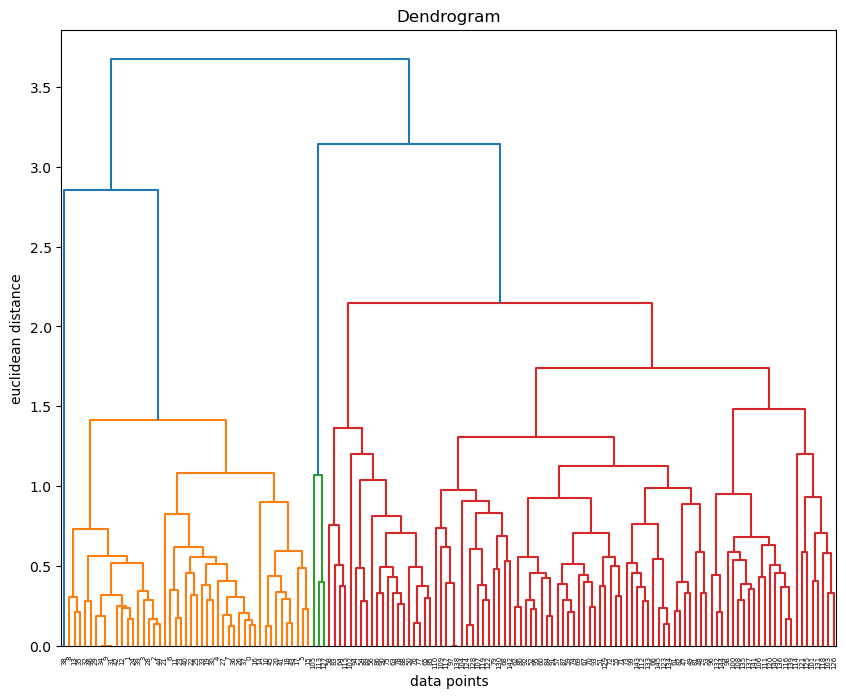

In [105]:
#Building a dendrogram. we will choose a number of clusters equal to 3.
# Calculate the linkage matrix
merg = linkage(X, method="average")

# Set the figure size before creating the dendrogram
plt.figure(figsize=(10, 8))  # You can adjust the width (10) and height (6) as per your preference

# Create the dendrogram
dendrogram(merg)

# Add labels and show the plot
plt.xlabel("data points")
plt.ylabel("euclidean distance")
plt.title("Dendrogram")
plt.show()

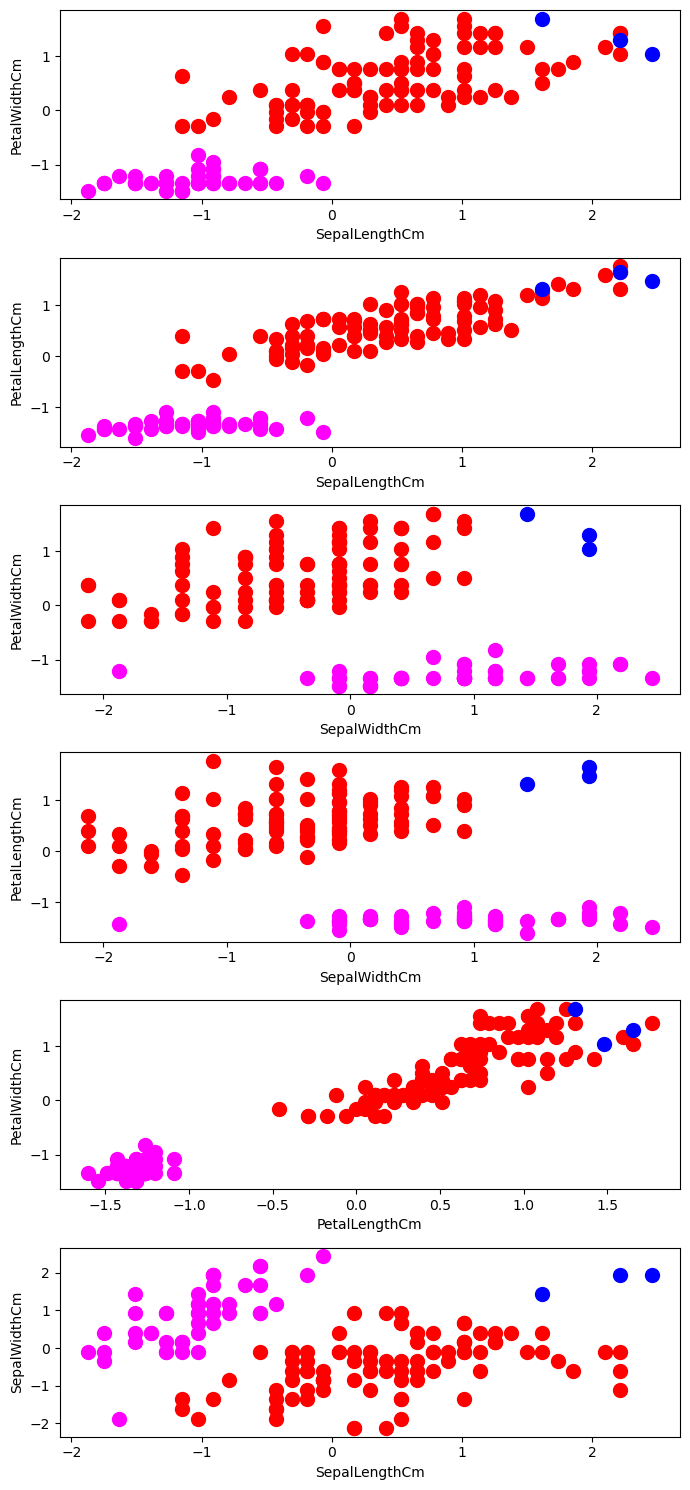

In [67]:
# Building the model and visualising the clusters
fig, axes = plt.subplots(nrows = 6, ncols=1, figsize=(7,15))
h_c = AgglomerativeClustering(n_clusters = 3,affinity= "euclidean",linkage = "average")
cluster_hc = h_c.fit_predict(X)
axes[0].scatter(X[cluster_hc==0,0],X[cluster_hc==0,3],s=100,c='magenta')
axes[0].scatter(X[cluster_hc==1,0],X[cluster_hc==1,3],s=100,c='red')
axes[0].scatter(X[cluster_hc==2,0],X[cluster_hc==2,3],s=100,c='blue')
axes[0].set_xlabel('SepalLengthCm')
axes[0].set_ylabel('PetalWidthCm')
axes[1].scatter(X[cluster_hc==0,0],X[cluster_hc==0,2],s=100,c='magenta')
axes[1].scatter(X[cluster_hc==1,0],X[cluster_hc==1,2],s=100,c='red')
axes[1].scatter(X[cluster_hc==2,0],X[cluster_hc==2,2],s=100,c='blue')
axes[1].set_xlabel('SepalLengthCm')
axes[1].set_ylabel('PetalLengthCm')
axes[2].scatter(X[cluster_hc==0,1],X[cluster_hc==0,3],s=100,c='magenta')
axes[2].scatter(X[cluster_hc==1,1],X[cluster_hc==1,3],s=100,c='red')
axes[2].scatter(X[cluster_hc==2,1],X[cluster_hc==2,3],s=100,c='blue')
axes[2].set_xlabel('SepalWidthCm')
axes[2].set_ylabel('PetalWidthCm')
axes[3].scatter(X[cluster_hc==0,1],X[cluster_hc==0,2],s=100,c='magenta')
axes[3].scatter(X[cluster_hc==1,1],X[cluster_hc==1,2],s=100,c='red')
axes[3].scatter(X[cluster_hc==2,1],X[cluster_hc==2,2],s=100,c='blue')
axes[3].set_xlabel('SepalWidthCm')
axes[3].set_ylabel('PetalLengthCm')
axes[4].scatter(X[cluster_hc==0,2],X[cluster_hc==0,3],s=100,c='magenta')
axes[4].scatter(X[cluster_hc==1,2],X[cluster_hc==1,3],s=100,c='red')
axes[4].scatter(X[cluster_hc==2,2],X[cluster_hc==2,3],s=100,c='blue')
axes[4].set_xlabel('PetalLengthCm')
axes[4].set_ylabel('PetalWidthCm')
axes[5].scatter(X[cluster_hc==0,0],X[cluster_hc==0,1],s=100,c='magenta')
axes[5].scatter(X[cluster_hc==1,0],X[cluster_hc==1,1],s=100,c='red')
axes[5].scatter(X[cluster_hc==2,0],X[cluster_hc==2,1],s=100,c='blue')
axes[5].set_xlabel('SepalLengthCm')
axes[5].set_ylabel('SepalWidthCm')
plt.tight_layout()

In [68]:
# We will now check in how many cases we have predicted the label correctly. 
# According to the analysis, conducted above, the clusters that represent Iris-setosa, should have a label of 0
# The clusters that represent Iris-versicolor, should have a label of 1
# The clusters that represent Iris-virginica, should have a label of 2
df2 = pd.DataFrame(cluster_hc)
df2.columns = ['predicted']
df2['actual'] = df['Species']
df2['actual_encoded'] = 1
df2.loc[df2['actual']=='Iris-setosa','actual_encoded'] = 0
df2.loc[df2['actual']=='Iris-virginica','actual_encoded'] = 2

In [69]:
# This model has performed slightly worse than Kmeans
accuracy_score(df2['actual_encoded'],df2['predicted'])

0.6643835616438356

In [70]:
# We can see that most of actual iris-virginica labels have been incorrectly labeled as iris-versicolor
confusion_matrix(df2['actual_encoded'],df2['predicted'])

array([[44,  3,  0],
       [ 3, 50,  0],
       [ 0, 43,  3]], dtype=int64)

# <span style="color:#873600; font-family: Trebuchet MS; font-size: 50px; font-weight: bold;">KMeans with PCA</span>

In [85]:
# We will reduce the dimension to 1 for the features: SepalLengthCm, PetalLengthCm, PetalWidthCm (stronly correlated)
# Standartization has already been done.
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X[:,[0,2,3]])
explained_variance = pca.explained_variance_ratio_

In [86]:
# We are explaining 92 % of variance with a single feature. That is a very good result.
explained_variance

array([0.92568067, 0.06402572])

In [87]:
#We will now concatenate the derived feature with SepalWidthCm, as it wasn't strongly correlated with the others
X_pca = np.concatenate((X_pca[:,0].reshape(-1,1), X[:,1].reshape(-1,1)), axis=1)

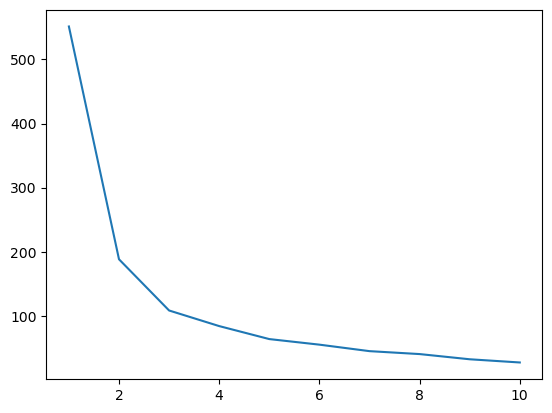

In [100]:
# We now have 2 main features to split the data into clusters.
#We will now use the elbow method to determine the optimal number of clusters.
#First we compute the squared sum of distances for each number of clusters chosen.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state= 123)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)

plt.show()

In [89]:
#As expected, the elbow method has predicted that the optimal cluster number is 3.
#Let's now check the average predicted silhouette for different numbers of clusters.
#The silhouette method predicts that the number of clusters = 2 is optimal. 
#However, based on the elbow method, and based on our knowledge of the label, we will use 3 as the number of clusters.
range_n_clusters = [2, 3, 4, 5, 6,7,8,9]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.6156179277897297
For n_clusters = 3 The average silhouette_score is : 0.5079794417995472
For n_clusters = 4 The average silhouette_score is : 0.48511501353134745
For n_clusters = 5 The average silhouette_score is : 0.43137888609220676
For n_clusters = 6 The average silhouette_score is : 0.424593599606103
For n_clusters = 7 The average silhouette_score is : 0.4353755997235125
For n_clusters = 8 The average silhouette_score is : 0.448824614612486
For n_clusters = 9 The average silhouette_score is : 0.4475040702897578


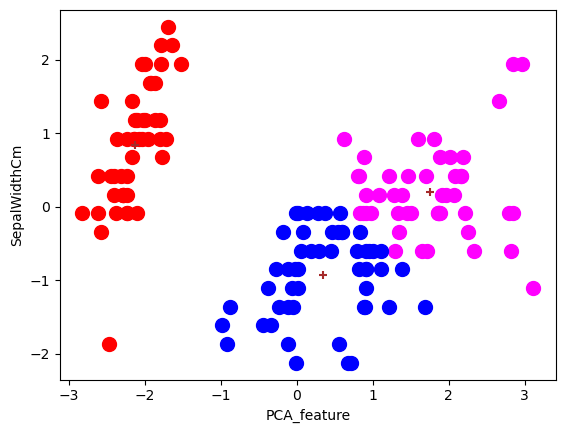

In [101]:
#Building the model and visualising the clusters. A satisfying separation has been achieved.
kmeans = KMeans(n_clusters = 3)
y_kmeans = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[y_kmeans==0,0],X_pca[y_kmeans==0,1],s=100,c='magenta')
plt.scatter(X_pca[y_kmeans==1,0],X_pca[y_kmeans==1,1],s=100,c='red')
plt.scatter(X_pca[y_kmeans==2,0],X_pca[y_kmeans==2,1],s=100,c='blue')
plt.xlabel('PCA_feature')
plt.ylabel('SepalWidthCm')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color = "brown",marker='+')

plt.show()

In [91]:
# We will now compute the accuracy of label assignment
df1 = pd.DataFrame(y_kmeans)
df1.columns = ['predicted']
df1['actual'] = df['Species']
df1['actual_encoded'] = 0
df1.loc[df1['actual']=='Iris-setosa','actual_encoded'] = 1
df1.loc[df1['actual']=='Iris-virginica','actual_encoded'] = 2

In [92]:
# We can see that the accuracy has increased after PCA.
accuracy_score(df1['actual_encoded'],df1['predicted'])

0.8082191780821918

In [93]:
confusion_matrix(df1['actual_encoded'],df1['predicted'])

array([[40,  3, 10],
       [ 0, 44,  3],
       [12,  0, 34]], dtype=int64)

# <span style="color:#873600; font-family: Trebuchet MS; font-size: 50px; font-weight: bold;">Hierarchical clustering with PCA</span>

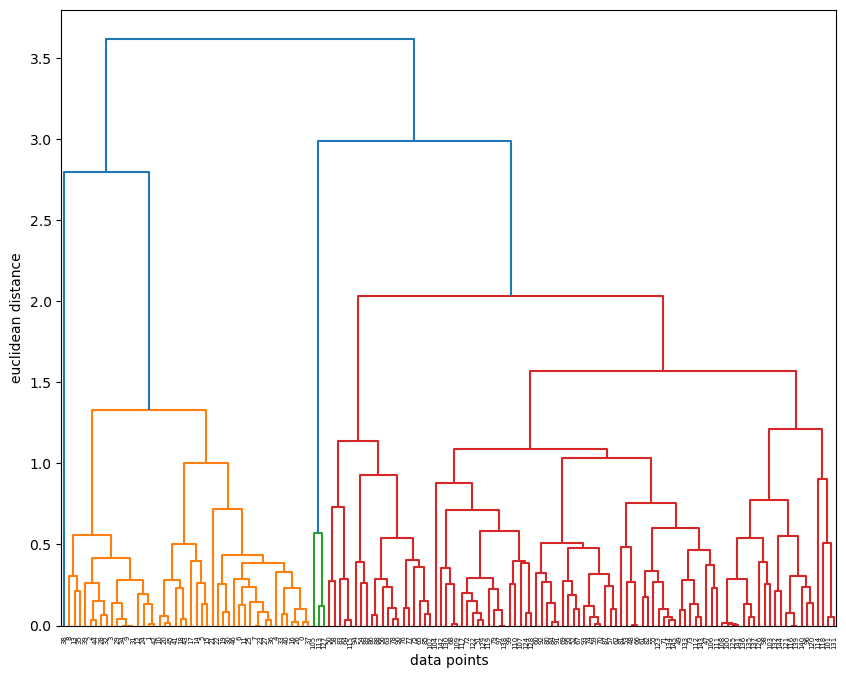

In [104]:
#Building a dendrogram. we will choose a number of clusters equal to 3.
plt.figure(figsize=(10, 8))
merg = linkage(X_pca,method="average")
dendrogram(merg)
plt.xlabel("data points")
plt.ylabel("euclidean distance")

plt.show()

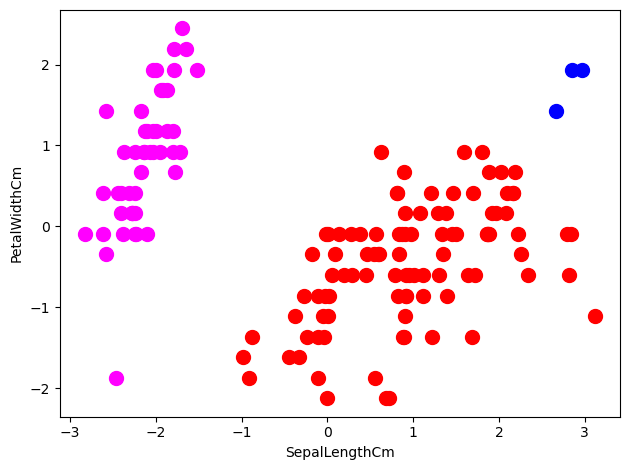

In [81]:
# Building the model and visualising the clusters
h_c = AgglomerativeClustering(n_clusters = 3,affinity= "euclidean",linkage = "average")
cluster_hc = h_c.fit_predict(X_pca)
plt.scatter(X_pca[cluster_hc==0,0],X_pca[cluster_hc==0,1],s=100,c='magenta')
plt.scatter(X_pca[cluster_hc==1,0],X_pca[cluster_hc==1,1],s=100,c='red')
plt.scatter(X_pca[cluster_hc==2,0],X_pca[cluster_hc==2,1],s=100,c='blue')
plt.xlabel('SepalLengthCm')
plt.ylabel('PetalWidthCm')
plt.tight_layout()

In [82]:
# We will now compute the accuracy of label assignment
df2 = pd.DataFrame(cluster_hc)
df2.columns = ['predicted']
df2['actual'] = df['Species']
df2['actual_encoded'] = 1
df2.loc[df2['actual']=='Iris-setosa','actual_encoded'] = 0
df2.loc[df2['actual']=='Iris-virginica','actual_encoded'] = 2

In [83]:
# This model has performed worse than Kmeans
accuracy_score(df2['actual_encoded'],df2['predicted'])

0.6643835616438356

In [84]:
confusion_matrix(df2['actual_encoded'],df2['predicted'])

array([[44,  3,  0],
       [ 3, 50,  0],
       [ 0, 43,  3]], dtype=int64)